7- PyTorch Experiment Tracking

What is experiment tracking?

Machine learning and deep learning are very experimental.

You have to put on your artist's beret/chef's hat to cook up lots of different models.

And you have to put on your scientist's coat to track the results of various combinations of data, model architectures and training regimes.

That's where **experiment tracking** comes in.

If you're running lots of different experiments, **experiment tracking helps you figure out what works and what doesn't**.


Different ways to track machine learning experiments

There are as many different ways to track machine learning experiments as there are experiments to run.

This table covers a few.

| **Method**                                                                        | **Setup**                                                                     | **Pros**                                                                     | **Cons**                                                                 | **Cost**              |
| --------------------------------------------------------------------------------- | ----------------------------------------------------------------------------- | ---------------------------------------------------------------------------- | ------------------------------------------------------------------------ | --------------------- |
| Python dictionaries, CSV files, print outs                                        | None                                                                          | Easy to setup, runs in pure Python                                           | Hard to keep track of large numbers of experiments                       | Free                  |
| [TensorBoard](https://www.tensorflow.org/tensorboard/get_started)                 | Minimal, install [`tensorboard`](https://pypi.org/project/tensorboard/)       | Extensions built into PyTorch, widely recognized and used, easily scales.    | User-experience not as nice as other options.                            | Free                  |
| [Weights & Biases Experiment Tracking](https://wandb.ai/site/experiment-tracking) | Minimal, install [`wandb`](https://docs.wandb.ai/quickstart), make an account | Incredible user experience, make experiments public, tracks almost anything. | Requires external resource outside of PyTorch.                           | Free for personal use |
| [MLFlow](https://mlflow.org/)                                                     | Minimal, install `mlflow` and start tracking                                  | Fully open-source MLOps lifecycle management, many integrations.             | Little bit harder to setup a remote tracking server than other services. | Free                  |


What we're going to cover

We're going to be running several different modelling experiments with various levels of data, model size and training time to try and improve on FoodVision Mini.

And due to its tight integration with PyTorch and widespread use, this notebook focuses on using TensorBoard to track our experiments.

However, the principles we're going to cover are similar across all of the other tools for experiment tracking.

| **Topic**                                                  | **Contents**                                                                                                                                                                                           |
| ---------------------------------------------------------- | ------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------ |
| **0. Getting setup**                                       | We've written a fair bit of useful code over the past few sections, let's download it and make sure we can use it again.                                                                               |
| **1. Get data**                                            | Let's get the pizza, steak and sushi image classification dataset we've been using to try and improve our FoodVision Mini model's results.                                                             |
| **2. Create Datasets and DataLoaders**                     | We'll use the `data_setup.py` script we wrote in chapter 05. PyTorch Going Modular to setup our DataLoaders.                                                                                           |
| **3. Get and customise a pretrained model**                | Just like the last section, 06. PyTorch Transfer Learning we'll download a pretrained model from `torchvision.models` and customise it to our own problem.                                             |
| **4. Train model and track results**                       | Let's see what it's like to train and track the training results of a single model using TensorBoard.                                                                                                  |
| **5. View our model's results in TensorBoard**             | Previously we visualized our model's loss curves with a helper function, now let's see what they look like in TensorBoard.                                                                             |
| **6. Creating a helper function to track experiments**     | If we're going to be adhering to the machine learner practitioner's motto of _experiment, experiment, experiment!_, we best create a function that will help us save our modelling experiment results. |
| **7. Setting up a series of modelling experiments**        | Instead of running experiments one by one, how about we write some code to run several experiments at once, with different models, different amounts of data and different training times.             |
| **8. View modelling experiments in TensorBoard**           | By this stage we'll have run eight modelling experiments in one go, a fair bit to keep track of, let's see what their results look like in TensorBoard.                                                |
| **9. Load in the best model and make predictions with it** | The point of experiment tracking is to figure out which model performs the best, let's load in the best performing model and make some predictions with it to _visualize, visualize, visualize!_.      |


0- Getting setup


In [1]:
try:
    import torch
    import torchvision
    assert int(torch.__version__.split(".")[1]) >= 12, "torch version should be 1.12+"
    assert int(torchvision.__version__.split(".")[1]) >= 13, "torchvision version should be 0.13+"
    print(f"torch version: {torch.__version__}")
    print(f"torchvision version: {torchvision.__version__}")
except:
    print(f"[INFO] torch/torchvision versions not as required, installing nightly versions.")
    !pip3 install -U torch torchvision torchaudio --extra-index-url https://download.pytorch.org/whl/cu113
    import torch
    import torchvision
    print(f"torch version: {torch.__version__}")
    print(f"torchvision version: {torchvision.__version__}")

[INFO] torch/torchvision versions not as required, installing nightly versions.
Looking in indexes: https://pypi.org/simple, https://download.pytorch.org/whl/cu113
torch version: 2.10.0
torchvision version: 0.25.0


In [2]:
import torch
import torchvision
import matplotlib.pyplot as plt

from torch import nn
from torchvision import transforms

# Try to get torchinfo, install it if it doesn't work 
try:
    from torchinfo import summary
except:
    print(f"[INFO] torchinfo not found, installing it.")
    !pip3 install -q torchinfo
    from torchinfo import summary

# Try to import the going_modular directory, download it from GitHub if it doesn't work 
try:
    from going_modular.going_modular import data_setup, engine 
except:
    print(f"[INFO] going_modular not found, downloading it from GitHub.")
    !git clone https://github.com/mrdbourke/pytorch-deep-learning
    !mv pytorch-deep-learning/going_modular .
    !rm -rf pytorch-deep-learning
    from going_modular.going_modular import data_setup, engine

In [ ]:
# device setup
device = "cpu"

In [ ]:
# St seeds with a helper function
def set_seeds(seed: int = 42):
    # for general torch operations
    torch.manual_seed(seed)
    # for cuda torch operations
    torch.cuda.manual_seed(seed)

1- Get data


In [ ]:
import os
import zipfile

from pathlib import Path

import requests


def download_data(source: str,
                  destination: str,
                  remove_source: bool = True) -> Path:
    """Downloads a zipped dataset from source and unzips to destination.

    Args:
        source (str): A link to a zipped file containing data.
        destination (str): A target directory to unzip data to.
        remove_source (bool): Whether to remove the source after downloading and extracting.

    Returns:
        pathlib.Path to downloaded data.

    Example usage:
        download_data(source="https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi.zip",
                      destination="pizza_steak_sushi")
    """
    # Setup path to data folder
    data_path = Path("data/")
    image_path = data_path / destination

    # If the image folder doesn't exist, download it and prepare it...
    if image_path.is_dir():
        print(f"[INFO] {image_path} directory exists, skipping download.")
    else:
        print(f"[INFO] Did not find {image_path} directory, creating one...")
        image_path.mkdir(parents=True, exist_ok=True)

        # Download pizza, steak, sushi data
        target_file = Path(source).name
        with open(data_path / target_file, "wb") as f:
            request = requests.get(source)
            print(f"[INFO] Downloading {target_file} from {source}...")
            f.write(request.content)

        # Unzip pizza, steak, sushi data
        with zipfile.ZipFile(data_path / target_file, "r") as zip_ref:
            print(f"[INFO] Unzipping {target_file} data...")
            zip_ref.extractall(image_path)

        # Remove .zip file
        if remove_source:
            os.remove(data_path / target_file)

    return image_path


image_path = download_data(source="https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi.zip",
                           destination="pizza_steak_sushi")
image_path

[INFO] data/pizza_steak_sushi directory exists, skipping download.


PosixPath('data/pizza_steak_sushi')

2- Create Datasets and DataLoaders


In [ ]:
# Need a normalize
normalize = transforms.Normalize(
    mean=[0.485, 0.465, 0.406],
    std=[0.229, 0.224, 0.225]
)

In [ ]:
# Create DataLoaders using manually created transforms
# Setup the directories
train_dir = image_path / "train"
test_dir = image_path / "test"

# Setup ImageNet normalization levels (turns all images into similar distribution as ImageNet)
normalize = transforms.Normalize(
    mean=[0.485, 0.465, 0.406],
    std=[0.229, 0.224, 0.225]
)

# Create transform pipeline manulally
manual_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    normalize
])
print(f"Manually created transforms: {manual_transforms}")

# Create DataLoaders
train_dataloader, test_dataloader, class_names = data_setup.create_dataloaders(
    train_dir=train_dir,
    test_dir=test_dir,
    transform=manual_transforms,
    batch_size=32
)

train_dataloader, test_dataloader, class_names

Manually created transforms: Compose(
    Resize(size=(224, 224), interpolation=bilinear, max_size=None, antialias=True)
    ToTensor()
    Normalize(mean=[0.485, 0.465, 0.406], std=[0.229, 0.224, 0.225])
)


(<torch.utils.data.dataloader.DataLoader at 0x12f5d1d30>,
 ['pizza', 'steak', 'sushi'])

2.2- Create DataLoaders using automatically created transforms


In [ ]:
# Setup dirs
train_dir = image_path / "train"
test_dir = image_path / "test"

# Setup pretrained weights (plenty of these available in torchvision.models)
weights = torchvision.models.EfficientNet_B0_Weights.DEFAULT

# Get transforms from weights (these are the transforms that were used to obtain the weights)
automatic_transforms = weights.transforms()
print(f"Automatically created transforms: {automatic_transforms}")

# Create data loaders
train_dataloader, test_dataloader, class_names = data_setup.create_dataloaders(
    train_dir=train_dir,
    test_dir=test_dir,
    transform=automatic_transforms,  # use automatic created transforms
    batch_size=32
)

train_dataloader, test_dataloader, class_names

Automatically created transforms: ImageClassification(
    crop_size=[224]
    resize_size=[256]
    mean=[0.485, 0.456, 0.406]
    std=[0.229, 0.224, 0.225]
    interpolation=InterpolationMode.BICUBIC
)


(<torch.utils.data.dataloader.DataLoader at 0x12f6111d0>,
 ['pizza', 'steak', 'sushi'])

3- Getting a pretrained model, freezing the base layers and changing the classifier head


In [9]:
weights = torchvision.models.EfficientNet_B0_Weights.DEFAULT

model = torchvision.models.efficientnet_b0(weights=weights).to(device)

In [ ]:
# Freeze all base layers by setting requires_grad attribute to False
for param in model.parameters():
    param.requires_grad = False

# Since we're creating a new layer with random weights (torch.nn.Linear)
# Set the seeds
set_seeds()

# Update the classsifier head to suit our problem
model.classifier = torch.nn.Sequential(
    nn.Dropout(p=0.2, inplace=True),
    nn.Linear(
        in_features=1280,
        out_features=len(class_names),
        bias=True
    )
).to(device)

In [ ]:
# Get a summary of the model
summary(
    model=model,
    input_size=(32, 3, 224, 224),
    verbose=0,
    col_names=["input_size", "output_size", "num_params", "trainable"],
    col_width=30,
    row_settings=["var_names"]
)

Layer (type (var_name))                                      Input Shape                    Output Shape                   Param #                        Trainable
EfficientNet (EfficientNet)                                  [32, 3, 224, 224]              [32, 3]                        --                             Partial
├─Sequential (features)                                      [32, 3, 224, 224]              [32, 1280, 7, 7]               --                             False
│    └─Conv2dNormActivation (0)                              [32, 3, 224, 224]              [32, 32, 112, 112]             --                             False
│    │    └─Conv2d (0)                                       [32, 3, 224, 224]              [32, 32, 112, 112]             (864)                          False
│    │    └─BatchNorm2d (1)                                  [32, 32, 112, 112]             [32, 32, 112, 112]             (64)                           False
│    │    └─SiLU (2)              

4- Train model and track results


In [ ]:
# Define the loss and optimizer
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [14]:
# Adjust train() function to track results with SummaryWriter()
# try:
#     from torch.utils.tensorboard import SummaryWriter
# except:
#     print("[INFO] Couldn't find tensorboard... installing it.")
#     !pip3 install -q tensorboard
#     from torch.utils.tensorboard import SummaryWriter

from torch.utils.tensorboard import SummaryWriter
print("Import successful")

writer = SummaryWriter()

Import successful


In [ ]:
from typing import Dict, List
from tqdm.auto import tqdm

from going_modular.going_modular.engine import train_step, test_step


def train(
        model: torch.nn.Module,
        train_dataloader: torch.utils.data.DataLoader,
        test_dataloader: torch.utils.data.DataLoader,
        optimizer: torch.optim.Optimizer,
        loss_fn: torch.nn.Module,
        epochs: int,
        device: torch.device,
) -> Dict[str, List]:
    """Trains and tests a PyTorch model and records results to TensorBoard.

    Args:
        model (torch.nn.Module): The PyTorch model to train and test.
        train_dataloader (torch.utils.data.DataLoader): A DataLoader instance for the training data.
        test_dataloader (torch.utils.data.DataLoader): A DataLoader instance for the testing data.
        optimizer (torch.optim.Optimizer): An optimizer instance for updating the model's parameters.
        loss_fn (torch.nn.Module): A loss function instance for calculating the loss.
        epochs (int): The number of epochs to train and test for.
        device (torch.device): The target device to compute on (e.g. "cuda" or "cpu").

    Returns:
        Dict[str, List]: A dictionary containing lists of training and testing losses and accuracies per epoch.
    """
    # Create empty results dictionary
    results = {
        "train_loss": [],
        "train_acc": [],
        "test_loss": [],
        "test_acc": []
    }

    # Loop through training and testing steps for a number of epochs
    for epoch in tqdm(range(epochs)):
        train_loss, train_acc = train_step(
            model=model,
            dataloader=train_dataloader,
            loss_fn=loss_fn,
            optimizer=optimizer,
            device=device
        )
        test_loss, test_acc = test_step(
            model=model,
            dataloader=test_dataloader,
            loss_fn=loss_fn,
            device=device
        )

        # Print out what's happening
        print(
            f"Epoch: {epoch+1} | "
            f"train_loss: {train_loss:.4f} | "
            f"train_acc: {train_acc:.4f} | "
            f"test_loss: {test_loss:.4f} | "
            f"test_acc: {test_acc:.4f}"
        )

        # Update results dictionary
        results["train_loss"].append(train_loss)
        results["train_acc"].append(train_acc)
        results["test_loss"].append(test_loss)
        results["test_acc"].append(test_acc)

        # NEW: Experiment tracking
        # Add loss results to SummaryWriter
        writer.add_scalars(
            main_tag="Loss",
            tag_scalar_dict={
                "train_loss": train_loss,
                "test_loss": test_loss
            },
            global_step=epoch
        )

        # Add accuracy results to SummaryWriter
        writer.add_scalars(
            main_tag="Accuracy",
            tag_scalar_dict={
                "train_acc": train_acc,
                "test_acc": test_acc
            },
            global_step=epoch
        )

        # Track the PyTorch model architecture
        writer.add_graph(
            model=model,
            input_to_model=torch.randn(32, 3, 224, 224).to(device)
        )

    # Close writer
    writer.close()

    # Return the filled results at the end of the epochs
    return results

In [ ]:
# Train model
set_seeds()
results = train(
    model=model,
    train_dataloader=train_dataloader,
    test_dataloader=test_dataloader,
    optimizer=optimizer,
    loss_fn=loss_fn,
    epochs=5,
    device=device
)

  0%|          | 0/5 [00:00<?, ?it/s]

/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/torch/utils/data/dataloader.py:1118: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, device pinned memory won't be used.
  super().__init__(loader)


Epoch: 1 | train_loss: 0.8143 | train_acc: 0.8398 | test_loss: 0.8119 | test_acc: 0.7955
Epoch: 2 | train_loss: 0.8176 | train_acc: 0.6953 | test_loss: 0.7350 | test_acc: 0.8153
Epoch: 3 | train_loss: 0.6601 | train_acc: 0.8789 | test_loss: 0.6772 | test_acc: 0.8456
Epoch: 4 | train_loss: 0.7348 | train_acc: 0.7266 | test_loss: 0.6369 | test_acc: 0.8144
Epoch: 5 | train_loss: 0.5835 | train_acc: 0.7734 | test_loss: 0.6048 | test_acc: 0.8362


In [ ]:
# Check the results
results

{'train_loss': [0.8142672330141068,
  0.8176154792308807,
  0.6600671038031578,
  0.7348025143146515,
  0.5835499465465546],
 'train_acc': [0.83984375, 0.6953125, 0.87890625, 0.7265625, 0.7734375],
 'test_loss': [0.8118696411450704,
  0.7349907755851746,
  0.6772497693697611,
  0.63692706823349,
  0.6047767996788025],
 'test_acc': [0.7954545454545454,
  0.8153409090909092,
  0.8456439393939394,
  0.8143939393939394,
  0.8361742424242425]}

5- View our model's results in TensorBoard

The `SummaryWriter()` class stores our model's results in a directory called `runs/` in TensorBoard format by default.

TensorBoard is a visualization program created by the TensorFlow team to view and inspect information about models and data.

You know what that means?

It's time to follow the data visualizer's motto and _visualize, visualize, visualize!_

You can view TensorBoard in a number of ways:

| Code environment                      | How to view TensorBoard                                                                                                                                                                  | Resource                                                                                                                                                             |
| ------------------------------------- | ---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------- | -------------------------------------------------------------------------------------------------------------------------------------------------------------------- |
| VS Code (notebooks or Python scripts) | Press `SHIFT + CMD + P` to open the Command Palette and search for the command "Python: Launch TensorBoard".                                                                             | [VS Code Guide on TensorBoard and PyTorch](https://code.visualstudio.com/docs/datascience/pytorch-support#_tensorboard-integration)                                  |
| Jupyter and Colab Notebooks           | Make sure [TensorBoard is installed](https://pypi.org/project/tensorboard/), load it with `%load_ext tensorboard` and then view your results with `%tensorboard --logdir DIR_WITH_LOGS`. | [`torch.utils.tensorboard`](https://pytorch.org/docs/stable/tensorboard.html) and [Get started with TensorBoard](https://www.tensorflow.org/tensorboard/get_started) |

Running the following code in a Google Colab or Jupyter Notebook will start an interactive TensorBoard session to view TensorBoard files in the `runs/` directory.


In [ ]:
# Example code to run in Jupyter or Google Colab Notebook (uncomment to try it out)
# %load_ext tensorboard
# %tensorboard --logdir runs

6- Create a helper function to build `SummaryWriter()` instances

For example, say we'd like to track things like:

- **Experiment date/timestamp** - when did the experiment take place?
- **Experiment name** - is there something we'd like to call the experiment?
- **Model name** - what model was used?
- **Extra** - should anything else be tracked?


In [ ]:
def create_writer(experiment_name: str,
                  model_name: str,
                  extra: str = None) -> torch.utils.tensorboard.writer.SummaryWriter():
    """Creates a torch.utils.tensorboard.writer.SummaryWriter() instance saving to a specific log_dir.

    log_dir is a combination of runs/timestamp/experiment_name/model_name/extra.

    Where timestamp is the current date in YYYY-MM-DD format.

    Args:
        experiment_name (str): Name of experiment.
        model_name (str): Name of model.
        extra (str, optional): Anything extra to add to the directory. Defaults to None.

    Returns:
        torch.utils.tensorboard.writer.SummaryWriter(): Instance of a writer saving to log_dir.

    Example usage:
        # Create a writer saving to "runs/2022-06-04/data_10_percent/effnetb2/5_epochs/"
        writer = create_writer(experiment_name="data_10_percent",
                               model_name="effnetb2",
                               extra="5_epochs")
        # The above is the same as:
        writer = SummaryWriter(log_dir="runs/2022-06-04/data_10_percent/effnetb2/5_epochs/")
    """
    from datetime import datetime
    import os

    # Get timestamp of current date (all experiments on certain day live in same folder)
    # returns current date in YYYY-MM-DD format
    timestamp = datetime.now().strftime("%Y-%m-%d")

    if extra:
        # Create log directory path
        log_dir = os.path.join(
            "runs", timestamp, experiment_name, model_name, extra)
    else:
        log_dir = os.path.join("runs", timestamp, experiment_name, model_name)

    print(f"[INFO] Created SummaryWriter, saving to: {log_dir}...")
    return SummaryWriter(log_dir=log_dir)

In [22]:
# Create an example writer
example_writer = create_writer(
    experiment_name="data_10_percent",
    model_name="effnetb0",
    extra="5_epochs")

[INFO] Created SummaryWriter, saving to: runs/2026-02-26/data_10_percent/effnetb0/5_epochs...


6.1- Update the `train()` function to include a `writer` parameter


In [ ]:
from typing import Dict, List
from tqdm.auto import tqdm

# Add writer parameter to train()


def train(
        model: torch.nn.Module,
        train_dataloader: torch.utils.data.DataLoader,
        test_dataloader: torch.utils.data.DataLoader,
        optimizer: torch.optim.Optimizer,
        loss_fn: torch.nn.Module,
        epochs: int,
        device: torch.device,
        # new parameter to take in a writer
        writer: torch.utils.tensorboard.writer.SummaryWriter
) -> Dict[str, List]:
    """Trains and tests a PyTorch model.

    Passes a target PyTorch models through train_step() and test_step()
    functions for a number of epochs, training and testing the model
    in the same epoch loop.

    Calculates, prints and stores evaluation metrics throughout.

    Stores metrics to specified writer log_dir if present.

    Args:
      model: A PyTorch model to be trained and tested.
      train_dataloader: A DataLoader instance for the model to be trained on.
      test_dataloader: A DataLoader instance for the model to be tested on.
      optimizer: A PyTorch optimizer to help minimize the loss function.
      loss_fn: A PyTorch loss function to calculate loss on both datasets.
      epochs: An integer indicating how many epochs to train for.
      device: A target device to compute on (e.g. "cuda" or "cpu").
      writer: A SummaryWriter() instance to log model results to.

    Returns:
      A dictionary of training and testing loss as well as training and
      testing accuracy metrics. Each metric has a value in a list for 
      each epoch.
      In the form: {train_loss: [...],
                train_acc: [...],
                test_loss: [...],
                test_acc: [...]} 
      For example if training for epochs=2: 
              {train_loss: [2.0616, 1.0537],
                train_acc: [0.3945, 0.3945],
                test_loss: [1.2641, 1.5706],
                test_acc: [0.3400, 0.2973]} 
    """
    # Create empty results dictionary
    results = {"train_loss": [],
               "train_acc": [],
               "test_loss": [],
               "test_acc": []
               }

    # Loop through training and testing steps for a number of epochs
    for epoch in tqdm(range(epochs)):
        train_loss, train_acc = train_step(
            model=model,
            dataloader=train_dataloader,
            loss_fn=loss_fn,
            optimizer=optimizer,
            device=device,
            writer=writer)
        test_loss, test_acc = test_step(model=model,
                                        dataloader=test_dataloader,
                                        loss_fn=loss_fn,
                                        device=device)

        # Print out what's happening
        print(
            f"Epoch: {epoch+1} | "
            f"train_loss: {train_loss:.4f} | "
            f"train_acc: {train_acc:.4f} | "
            f"test_loss: {test_loss:.4f} | "
            f"test_acc: {test_acc:.4f}"
        )

        # Update results dictionary
        results["train_loss"].append(train_loss)
        results["train_acc"].append(train_acc)
        results["test_loss"].append(test_loss)
        results["test_acc"].append(test_acc)

        ### New: Use the writer parameter to track experiments ###
        # See if there's a writer, if so, log to it
        if writer:
            # Add results to SummaryWriter
            writer.add_scalars(
                main_tag="Loss",
                tag_scalar_dict={
                    "train_loss": train_loss,
                    "test_loss": test_loss},
                global_step=epoch)
            writer.add_scalars(
                main_tag="Accuracy",
                tag_scalar_dict={
                    "train_acc": train_acc,
                    "test_acc": test_acc},
                global_step=epoch)

            # Close the writer
            writer.close()
        else:
            pass
    ### End new ###

    # Return the filled results at the end of the epochs
    return results

7- Setting up a series of modelling experiments


7.1- What kind of experiments should you run?

Every hyperparameter stands as a starting point for a different experiment:

- Change the number of **epochs**.
- Change the number of **layers/hidden units**.
- Change the amount of **data**.
- Change the **learning rate**.
- Try different kinds of **data augmentation**.
- Choose a different **model architecture**.


7.2- What experiments are we going to run?

Let's try a combination of:

1. A different amount of data (10% of Pizza, Steak, Sushi vs. 20%)
2. A different model ([`torchvision.models.efficientnet_b0`](https://pytorch.org/vision/stable/generated/torchvision.models.efficientnet_b0.html#torchvision.models.efficientnet_b0) vs. [`torchvision.models.efficientnet_b2`](https://pytorch.org/vision/stable/generated/torchvision.models.efficientnet_b2.html#torchvision.models.efficientnet_b2))
3. A different training time (5 epochs vs. 10 epochs)

Breaking these down we get:

| Experiment number | Training Dataset                | Model (pretrained on ImageNet) | Number of epochs |
| ----------------- | ------------------------------- | ------------------------------ | ---------------- |
| 1                 | Pizza, Steak, Sushi 10% percent | EfficientNetB0                 | 5                |
| 2                 | Pizza, Steak, Sushi 10% percent | EfficientNetB2                 | 5                |
| 3                 | Pizza, Steak, Sushi 10% percent | EfficientNetB0                 | 10               |
| 4                 | Pizza, Steak, Sushi 10% percent | EfficientNetB2                 | 10               |
| 5                 | Pizza, Steak, Sushi 20% percent | EfficientNetB0                 | 5                |
| 6                 | Pizza, Steak, Sushi 20% percent | EfficientNetB2                 | 5                |
| 7                 | Pizza, Steak, Sushi 20% percent | EfficientNetB0                 | 10               |
| 8                 | Pizza, Steak, Sushi 20% percent | EfficientNetB2                 | 10               |

Notice how we're slowly scaling things up.

With each experiment we slowly increase the amount of data, the model size and the length of training.

By the end, experiment 8 will be using double the data, double the model size and double the length of training compared to experiment 1.

> **Note:** I want to be clear that there truly is no limit to amount of experiments you can run. What we've designed here is only a very small subset of options. However, you can't test _everything_ so best to try a few things to begin with and then follow the ones which work the best.
>
> And as a reminder, the datasets we're using are a subset of the [Food101 dataset](https://pytorch.org/vision/stable/generated/torchvision.datasets.Food101.html#torchvision.datasets.Food101) (3 classes, pizza, steak, suhsi, instead of 101) and 10% and 20% of the images rather than 100%. If our experiments work, we could start to run more on more data (though this will take longer to compute). You can see how the datasets were created via the [`04_custom_data_creation.ipynb` notebook](https://github.com/mrdbourke/pytorch-deep-learning/blob/main/extras/04_custom_data_creation.ipynb).


7.3- Download different datasets

We'll need two forms of a training set:

1. A training set with **10% of the data** of Food101 pizza, steak, sushi images (we've already created this above but we'll do it again for completeness).
2. A training set with **20% of the data** of Food101 pizza, steak, sushi images.

For consistency, all experiments will use the same testing dataset (the one from the 10% data split).

We'll start by downloading the various datasets we need using the `download_data()` function we created earlier.

Both datasets are available from the course GitHub:

1. [Pizza, steak, sushi 10% training data](https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi.zip).
2. [Pizza, steak, sushi 20% training data](https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi_20_percent.zip).


In [24]:
# Download 10 percent and 20 percent training data (if necessary)
data_10_percent_path = download_data(
    source="https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi.zip",
    destination="pizza_steak_sushi")

data_20_percent_path = download_data(
    source="https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi_20_percent.zip",
    destination="pizza_steak_sushi_20_percent")

[INFO] data/pizza_steak_sushi directory exists, skipping download.
[INFO] Did not find data/pizza_steak_sushi_20_percent directory, creating one...
[INFO] Downloading pizza_steak_sushi_20_percent.zip from https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi_20_percent.zip...
[INFO] Unzipping pizza_steak_sushi_20_percent.zip data...


In [25]:
# Setup training directory paths
train_dir_10_percent = data_10_percent_path / "train"
train_dir_20_percent = data_20_percent_path / "train"

# Setup testing directory paths (note: use the same test dataset for both to compare the results)
test_dir = data_10_percent_path / "test"

# Check the directories
print(f"Training directory 10%: {train_dir_10_percent}")
print(f"Training directory 20%: {train_dir_20_percent}")
print(f"Testing directory: {test_dir}")

Training directory 10%: data/pizza_steak_sushi/train
Training directory 20%: data/pizza_steak_sushi_20_percent/train
Testing directory: data/pizza_steak_sushi/test


7.4- Transform Datasets and create DataLoaders

The transform will:

1. Resize all the images (we'll start with 224, 224 but this could be changed).
2. Turn them into tensors with values between 0 & 1.
3. Normalize them in way so their distributions are inline with the ImageNet dataset (we do this because our models from [`torchvision.models`](https://pytorch.org/vision/stable/models.html) have been pretrained on ImageNet).


In [ ]:
from torchvision import transforms

# Create a transform to normalize data distribution to be inline with ImageNet
normalize = transforms.Normalize(
    mean=[0.485, 0.465, 0.406],  # values per colour channel [red, green, blue]
    std=[0.229, 0.224, 0.225]  # values per colour channel [red, green, blue]
)

# Compose transforms into a pipeline
simple_transform = transforms.Compose([
    transforms.Resize((224, 224)),  # 1. Resize the images
    transforms.ToTensor(),  # 2. Turn the images into tensors with values between 0 & 1
    normalize  # 3. Normalize the images so their distributions match the ImageNet dataset
])

In [ ]:
BATCH_SIZE = 32

# Create 10% training and test Dataloaders
train_dataloader_10_percent, test_dataloader, class_names = data_setup.create_dataloaders(
    train_dir=train_dir_10_percent,
    test_dir=test_dir,
    transform=simple_transform,
    batch_size=BATCH_SIZE
)

# Create 20% training and test Dataloaders
train_dataloader_20_percent, test_dataloader, class_names = data_setup.create_dataloaders(
    train_dir=train_dir_20_percent,
    test_dir=test_dir,
    transform=simple_transform,
    batch_size=BATCH_SIZE
)

# Find the number of samples/batches per dataloader (using the same test_dataloader for both experiments)
print(
    f"Number of batches of size {BATCH_SIZE} in 10 percent training data: {len(train_dataloader_10_percent)}")
print(
    f"Number of batches of size {BATCH_SIZE} in 20 percent training data: {len(train_dataloader_20_percent)}")
print(
    f"Number of batches of size {BATCH_SIZE} in testing data: {len(test_dataloader)} (all experiments will use the same test set)")
print(f"Number of classes: {len(class_names)}, class names: {class_names}")

Number of batches of size 32 in 10 percent training data: 8
Number of batches of size 32 in 20 percent training data: 15
Number of batches of size 32 in testing data: 3 (all experiments will use the same test set)
Number of classes: 3, class names: ['pizza', 'steak', 'sushi']


7.5- Create feature extractor models

We're going to create two feature extractor models:

1. [`torchvision.models.efficientnet_b0()`](https://pytorch.org/vision/main/models/generated/torchvision.models.efficientnet_b0.html) pretrained backbone + custom classifier head (EffNetB0 for short).
2. [`torchvision.models.efficientnet_b2()`](https://pytorch.org/vision/main/models/generated/torchvision.models.efficientnet_b2.html) pretrained backbone + custom classifier head (EffNetB2 for short).


In [ ]:
import torchvision
from torchinfo import summary

# 1- Create an instance of EffNetB2 with pretrained weights
effnetb2_weights = torchvision.models.EfficientNet_B2_Weights.DEFAULT
effnetb2 = torchvision.models.efficientnet_b2(weights=effnetb2_weights)

# 2- Get a summary of standard EffnetB2 from torchvision.models
summary(
    model=effnetb2,
    input_size=(32, 3, 224, 224),
    col_names=["input_size", "output_size", "num_params", "trainable"],
    col_width=20,
    row_settings=["var_names"]
)

# 3- Get the number of in_features of the EfficientNetB2 classifier layer
print(
    f"Number of in_features to final layer of EfficientNetB2: {len(effnetb2.classifier.state_dict()['1.weight'][0])}")

Downloading: "https://download.pytorch.org/models/efficientnet_b2_rwightman-c35c1473.pth" to /Users/zhouwende/.cache/torch/hub/checkpoints/efficientnet_b2_rwightman-c35c1473.pth


100%|██████████| 35.2M/35.2M [00:00<00:00, 50.0MB/s]


Number of in_features to final layer of EfficientNetB2: 1408


In [ ]:
import torchvision
from torch import nn

# Get num out features (one for each class pizza, steak, sushi)
OUT_FEATURES = len(class_names)

# Create an EffNetB0 feature extractor


def create_effnetb0():
    # 1- Get the base model with pretrained weights and send to target device
    weights = torchvision.models.EfficientNet_B0_Weights.DEFAULT
    model = torchvision.models.efficientnet_b0(weights=weights).to(device)

    # 2- Freeze the base model layers
    for param in model.features.parameters():
        param.requires_grad = False

    # 3- Set the seeds
    set_seeds()

    # 4- Change the classifier head
    model.classifier = nn.Sequential(
        nn.Dropout(p=0.2),
        nn.Linear(
            in_features=1280,
            out_features=OUT_FEATURES
        )
    ).to(device)

    # 5- Give the model a name
    model.name = "effnetb0"
    print(f"[INFO] Created new {model.name} model.")
    return model

# Create an EffNetB2 feature extractor


def create_effnetb2():
    # 1- Get the base model with pretrained weights and send to target device
    weights = torchvision.models.EfficientNet_B2_Weights.DEFAULT
    model = torchvision.models.efficientnet_b2(weights=weights).to(device)

    # 2- Freeze the base model layers
    for param in model.features.parameters():
        param.requires_grad = False

    # 3- Set the seeds
    set_seeds()

    # 4- Change the classifier head
    model.classifier = nn.Sequential(
        nn.Dropout(p=0.3),
        nn.Linear(
            in_features=1408,
            out_features=OUT_FEATURES,
        )
    ).to(device)

    # 5- Give the model a name
    model.name = "effnetb2"
    print(f"[INFO] Created new {model.name} model.")
    return model

In [ ]:
effnetb0 = create_effnetb0()

# Get an output summary of the layers in our EffNetB0 feature extractor model
summary(
    model=effnetb0,
    input_size=(32, 3, 224, 224),
    # col_names=["input_size"],
    col_names=["input_size", "output_size", "num_params", "trainable"],
    col_width=20,
    row_settings=["var_names"]
)

[INFO] Created new effnetb0 model.


Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
EfficientNet (EfficientNet)                                  [32, 3, 224, 224]    [32, 3]              --                   Partial
├─Sequential (features)                                      [32, 3, 224, 224]    [32, 1280, 7, 7]     --                   False
│    └─Conv2dNormActivation (0)                              [32, 3, 224, 224]    [32, 32, 112, 112]   --                   False
│    │    └─Conv2d (0)                                       [32, 3, 224, 224]    [32, 32, 112, 112]   (864)                False
│    │    └─BatchNorm2d (1)                                  [32, 32, 112, 112]   [32, 32, 112, 112]   (64)                 False
│    │    └─SiLU (2)                                         [32, 32, 112, 112]   [32, 32, 112, 112]   --                   --
│    └─Sequential (1)                                        [32, 32, 112, 112]   [32, 

In [ ]:
effnetb2 = create_effnetb2()

# Get an output summary of the layers in our EffNetB0 feature extractor model
summary(
    model=effnetb2,
    input_size=(32, 3, 224, 224),
    # col_names=["input_size"],
    col_names=["input_size", "output_size", "num_params", "trainable"],
    col_width=20,
    row_settings=["var_names"]
)

[INFO] Created new effnetb2 model.


Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
EfficientNet (EfficientNet)                                  [32, 3, 224, 224]    [32, 3]              --                   Partial
├─Sequential (features)                                      [32, 3, 224, 224]    [32, 1408, 7, 7]     --                   False
│    └─Conv2dNormActivation (0)                              [32, 3, 224, 224]    [32, 32, 112, 112]   --                   False
│    │    └─Conv2d (0)                                       [32, 3, 224, 224]    [32, 32, 112, 112]   (864)                False
│    │    └─BatchNorm2d (1)                                  [32, 32, 112, 112]   [32, 32, 112, 112]   (64)                 False
│    │    └─SiLU (2)                                         [32, 32, 112, 112]   [32, 32, 112, 112]   --                   --
│    └─Sequential (1)                                        [32, 32, 112, 112]   [32, 

Looking at the outputs of the summaries, it seems the EffNetB2 backbone has nearly double the amount of parameters as EffNetB0.

| Model          | Total parameters (before freezing/changing head) | Total parameters (after freezing/changing head) | Total trainable parameters (after freezing/changing head) |
| -------------- | ------------------------------------------------ | ----------------------------------------------- | --------------------------------------------------------- |
| EfficientNetB0 | 5,288,548                                        | 4,011,391                                       | 3,843                                                     |
| EfficientNetB2 | 9,109,994                                        | 7,705,221                                       | 4,227                                                     |

This gives the backbone of the EffNetB2 model more opportunities to form a representation of our pizza, steak and sushi data.


7.6- Create experiments and set up training code

We'll start by creating two lists and a dictionary:

1. A list of the number of epochs we'd like to test (`[5, 10]`)
2. A list of the models we'd like to test (`["effnetb0", "effnetb2"]`)
3. A dictionary of the different training DataLoaders


In [ ]:
# 1- Create a epochs list
num_epochs = [5, 10]

# 2- Create models' list (needed to create a new model for each experiment)
models = ["effnetb0", "effnetb2"]

# 3- Create dataloaders dictionary for various dataloaders
train_dataloaders = {
    "data_10_percent": train_dataloader_10_percent,
    "data_20_percent": train_dataloader_20_percent
}

Specifically, let's go through the following steps:

1. Set the random seeds (so our experiment results are reproducible, in practice, you might run the same experiment across ~3 different seeds and average the results).
2. Keep track of different experiment numbers (this is mostly for pretty print outs).
3. Loop through the `train_dataloaders` dictionary items for each of the different training DataLoaders.
4. Loop through the list of epoch numbers.
5. Loop through the list of different model names.
6. Create information print outs for the current running experiment (so we know what's happening).
7. Check which model is the target model and create a new EffNetB0 or EffNetB2 instance (we create a new model instance each experiment so all models start from the same standpoint).
8. Create a new loss function (`torch.nn.CrossEntropyLoss()`) and optimizer (`torch.optim.Adam(params=model.parameters(), lr=0.001)`) for each new experiment.
9. Train the model with the modified `train()` function passing the appropriate details to the `writer` parameter.
10. Save the trained model with an appropriate file name to file with `save_model()` from [`utils.py`](https://github.com/mrdbourke/pytorch-deep-learning/blob/main/going_modular/going_modular/utils.py).

We can also use the `%%time` magic to see how long all of our experiments take together in a single Jupyter/Google Colab cell.

Let's do it!


In [51]:
%%time 
from going_modular.going_modular.utils import save_model

# 1- Set the random seeds 
set_seeds(seed=42)

# 2- Keep track of experiment numbers 
experiment_number = 0

# 3- Loop through each DataLoader 
for dataloader_name, train_dataloader in train_dataloaders.items():

    # 4- Loop through each number of epochs 
    for epochs in num_epochs:

        # 5- Loop through each model name and create a new model based on the name 
        for model_name in models:

            # 6- Create information print outs 
            experiment_number += 1
            print(f"[INFO] Experiment number: {experiment_number}")
            print(f"[INFO] Model: {model_name}")
            print(f"[INFO] DataLoader: {dataloader_name}")
            print(f"[INFO] Number of epochs: {epochs}")  

            # 7- Select the model 
            if model_name == "effnetb0":
                model = create_effnetb0()
            else:
                model = create_effnetb2()

            # 8- Create a new loss and optimizer for every model
            loss_fn = nn.CrossEntropyLoss()
            optimizer = torch.optim.Adam(params=model.parameters(), lr=0.001)

            # 9- Train target model with target dataloaders and track experiments 
            train(
                model=model,
                train_dataloader=train_dataloader,
                test_dataloader=test_dataloader,
                optimizer=optimizer,
                loss_fn=loss_fn,
                epochs=epochs,
                device=device,
                # writer=create_writer(
                #     experiment_name=dataloader_name,
                #     model_name=model_name,
                #     extra=f"{epochs}_epochs"
                # )
            )

        # 10- Save the model to file so we can get back the best model 
        save_filepath = f"07_{model_name}_{dataloader_name}_{epochs}_epochs.pth"
        save_model(
            model=model,
            target_dir="models",
            model_name=save_filepath
        )
        print("-"*50 + "\n")

[INFO] Experiment number: 1
[INFO] Model: effnetb0
[INFO] DataLoader: data_10_percent
[INFO] Number of epochs: 5
[INFO] Created new effnetb0 model.


  0%|          | 0/5 [00:00<?, ?it/s]

/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/torch/utils/data/dataloader.py:1118: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, device pinned memory won't be used.
  super().__init__(loader)


Epoch: 1 | train_loss: 1.0497 | train_acc: 0.4453 | test_loss: 0.9292 | test_acc: 0.4470
Epoch: 2 | train_loss: 0.9426 | train_acc: 0.5469 | test_loss: 0.8310 | test_acc: 0.6108
Epoch: 3 | train_loss: 0.7898 | train_acc: 0.7305 | test_loss: 0.7346 | test_acc: 0.7936
Epoch: 4 | train_loss: 0.6815 | train_acc: 0.8633 | test_loss: 0.6578 | test_acc: 0.8769
Epoch: 5 | train_loss: 0.5958 | train_acc: 0.8828 | test_loss: 0.6214 | test_acc: 0.8873
[INFO] Experiment number: 2
[INFO] Model: effnetb2
[INFO] DataLoader: data_10_percent
[INFO] Number of epochs: 5
[INFO] Created new effnetb2 model.


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 1.0924 | train_acc: 0.3906 | test_loss: 0.9374 | test_acc: 0.7519
Epoch: 2 | train_loss: 0.9350 | train_acc: 0.6836 | test_loss: 0.8943 | test_acc: 0.7737
Epoch: 3 | train_loss: 0.8157 | train_acc: 0.7227 | test_loss: 0.7527 | test_acc: 0.9072
Epoch: 4 | train_loss: 0.7032 | train_acc: 0.7500 | test_loss: 0.7230 | test_acc: 0.8153
Epoch: 5 | train_loss: 0.7206 | train_acc: 0.7695 | test_loss: 0.6743 | test_acc: 0.9072
[INFO] Saving model to: models/07_effnetb2_data_10_percent_5_epochs.pth
--------------------------------------------------

[INFO] Experiment number: 3
[INFO] Model: effnetb0
[INFO] DataLoader: data_10_percent
[INFO] Number of epochs: 10
[INFO] Created new effnetb0 model.


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 1.0497 | train_acc: 0.4453 | test_loss: 0.9292 | test_acc: 0.4470
Epoch: 2 | train_loss: 0.9426 | train_acc: 0.5469 | test_loss: 0.8310 | test_acc: 0.6108
Epoch: 3 | train_loss: 0.7898 | train_acc: 0.7305 | test_loss: 0.7346 | test_acc: 0.7936
Epoch: 4 | train_loss: 0.6815 | train_acc: 0.8633 | test_loss: 0.6578 | test_acc: 0.8769
Epoch: 5 | train_loss: 0.5958 | train_acc: 0.8828 | test_loss: 0.6214 | test_acc: 0.8873
Epoch: 6 | train_loss: 0.6667 | train_acc: 0.7422 | test_loss: 0.5681 | test_acc: 0.8873
Epoch: 7 | train_loss: 0.5651 | train_acc: 0.8906 | test_loss: 0.5370 | test_acc: 0.9072
Epoch: 8 | train_loss: 0.4720 | train_acc: 0.9492 | test_loss: 0.5422 | test_acc: 0.8759
Epoch: 9 | train_loss: 0.5849 | train_acc: 0.7773 | test_loss: 0.5151 | test_acc: 0.8864
Epoch: 10 | train_loss: 0.4935 | train_acc: 0.7812 | test_loss: 0.4423 | test_acc: 0.8864
[INFO] Experiment number: 4
[INFO] Model: effnetb2
[INFO] DataLoader: data_10_percent
[INFO] Number of epochs

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 1.0924 | train_acc: 0.3906 | test_loss: 0.9374 | test_acc: 0.7519
Epoch: 2 | train_loss: 0.9350 | train_acc: 0.6836 | test_loss: 0.8943 | test_acc: 0.7737
Epoch: 3 | train_loss: 0.8157 | train_acc: 0.7227 | test_loss: 0.7527 | test_acc: 0.9072
Epoch: 4 | train_loss: 0.7032 | train_acc: 0.7500 | test_loss: 0.7230 | test_acc: 0.8153
Epoch: 5 | train_loss: 0.7206 | train_acc: 0.7695 | test_loss: 0.6743 | test_acc: 0.9072
Epoch: 6 | train_loss: 0.6193 | train_acc: 0.7891 | test_loss: 0.6664 | test_acc: 0.8570
Epoch: 7 | train_loss: 0.6293 | train_acc: 0.7969 | test_loss: 0.6629 | test_acc: 0.8570
Epoch: 8 | train_loss: 0.4926 | train_acc: 0.9414 | test_loss: 0.5919 | test_acc: 0.9176
Epoch: 9 | train_loss: 0.5263 | train_acc: 0.7695 | test_loss: 0.5346 | test_acc: 0.9176
Epoch: 10 | train_loss: 0.4780 | train_acc: 0.9180 | test_loss: 0.5543 | test_acc: 0.9072
[INFO] Saving model to: models/07_effnetb2_data_10_percent_10_epochs.pth
------------------------------------

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 0.9679 | train_acc: 0.5563 | test_loss: 0.6608 | test_acc: 0.8655
Epoch: 2 | train_loss: 0.6778 | train_acc: 0.8417 | test_loss: 0.5711 | test_acc: 0.9072
Epoch: 3 | train_loss: 0.5493 | train_acc: 0.8750 | test_loss: 0.4540 | test_acc: 0.9072
Epoch: 4 | train_loss: 0.4622 | train_acc: 0.8938 | test_loss: 0.4099 | test_acc: 0.9176
Epoch: 5 | train_loss: 0.4617 | train_acc: 0.8792 | test_loss: 0.4039 | test_acc: 0.8769
[INFO] Experiment number: 6
[INFO] Model: effnetb2
[INFO] DataLoader: data_20_percent
[INFO] Number of epochs: 5
[INFO] Created new effnetb2 model.


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 0.9806 | train_acc: 0.5354 | test_loss: 0.7978 | test_acc: 0.8049
Epoch: 2 | train_loss: 0.7483 | train_acc: 0.7917 | test_loss: 0.6697 | test_acc: 0.8561
Epoch: 3 | train_loss: 0.5664 | train_acc: 0.8958 | test_loss: 0.5740 | test_acc: 0.8977
Epoch: 4 | train_loss: 0.5191 | train_acc: 0.8812 | test_loss: 0.4942 | test_acc: 0.8968
Epoch: 5 | train_loss: 0.5245 | train_acc: 0.8479 | test_loss: 0.4884 | test_acc: 0.8873
[INFO] Saving model to: models/07_effnetb2_data_20_percent_5_epochs.pth
--------------------------------------------------

[INFO] Experiment number: 7
[INFO] Model: effnetb0
[INFO] DataLoader: data_20_percent
[INFO] Number of epochs: 10
[INFO] Created new effnetb0 model.


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 0.9679 | train_acc: 0.5563 | test_loss: 0.6608 | test_acc: 0.8655
Epoch: 2 | train_loss: 0.6778 | train_acc: 0.8417 | test_loss: 0.5711 | test_acc: 0.9072
Epoch: 3 | train_loss: 0.5493 | train_acc: 0.8750 | test_loss: 0.4540 | test_acc: 0.9072
Epoch: 4 | train_loss: 0.4622 | train_acc: 0.8938 | test_loss: 0.4099 | test_acc: 0.9176
Epoch: 5 | train_loss: 0.4617 | train_acc: 0.8792 | test_loss: 0.4039 | test_acc: 0.8769
Epoch: 6 | train_loss: 0.4083 | train_acc: 0.8812 | test_loss: 0.3253 | test_acc: 0.9072
Epoch: 7 | train_loss: 0.3572 | train_acc: 0.9250 | test_loss: 0.3304 | test_acc: 0.9280
Epoch: 8 | train_loss: 0.4107 | train_acc: 0.8750 | test_loss: 0.3224 | test_acc: 0.9176
Epoch: 9 | train_loss: 0.3203 | train_acc: 0.9187 | test_loss: 0.3249 | test_acc: 0.8977
Epoch: 10 | train_loss: 0.3625 | train_acc: 0.8562 | test_loss: 0.2877 | test_acc: 0.9176
[INFO] Experiment number: 8
[INFO] Model: effnetb2
[INFO] DataLoader: data_20_percent
[INFO] Number of epochs

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 0.9806 | train_acc: 0.5354 | test_loss: 0.7978 | test_acc: 0.8049
Epoch: 2 | train_loss: 0.7483 | train_acc: 0.7917 | test_loss: 0.6697 | test_acc: 0.8561
Epoch: 3 | train_loss: 0.5664 | train_acc: 0.8958 | test_loss: 0.5740 | test_acc: 0.8977
Epoch: 4 | train_loss: 0.5191 | train_acc: 0.8812 | test_loss: 0.4942 | test_acc: 0.8968
Epoch: 5 | train_loss: 0.5245 | train_acc: 0.8479 | test_loss: 0.4884 | test_acc: 0.8873
Epoch: 6 | train_loss: 0.4071 | train_acc: 0.9042 | test_loss: 0.4357 | test_acc: 0.9280
Epoch: 7 | train_loss: 0.3712 | train_acc: 0.9000 | test_loss: 0.4182 | test_acc: 0.9280
Epoch: 8 | train_loss: 0.3604 | train_acc: 0.9104 | test_loss: 0.4430 | test_acc: 0.8873
Epoch: 9 | train_loss: 0.3364 | train_acc: 0.9083 | test_loss: 0.4154 | test_acc: 0.8977
Epoch: 10 | train_loss: 0.3172 | train_acc: 0.9187 | test_loss: 0.3868 | test_acc: 0.9280
[INFO] Saving model to: models/07_effnetb2_data_20_percent_10_epochs.pth
------------------------------------

8- View experiments in TensorBoard


In [ ]:
# Viewing TensorBoard in Jupyter and Google Colab Notebooks (uncomment to view full TensorBoard instance)
# %load_ext tensorboard
# %tensorboard --logdir runs

9- Load in the best model and make predictions with it


In [52]:
# Setup the best model filepath
best_model_path = "models/07_effnetb2_data_20_percent_10_epochs.pth"

# Instantiate a new instance of EffNetB2 (to load the saved state_dict() to)
best_model = create_effnetb2()

# Load the saved best model state_dict()
best_model.load_state_dict(torch.load(best_model_path))

[INFO] Created new effnetb2 model.


<All keys matched successfully>

In [53]:
# Check the model file size
from pathlib import Path

# Get the model size in bytes then convert to megabytes
effnetb2_model_size = Path(best_model_path).stat().st_size // (1024*1024)
print(f"EfficientNetB2 feature extractor model size: {effnetb2_model_size} MB")

EfficientNetB2 feature extractor model size: 29 MB


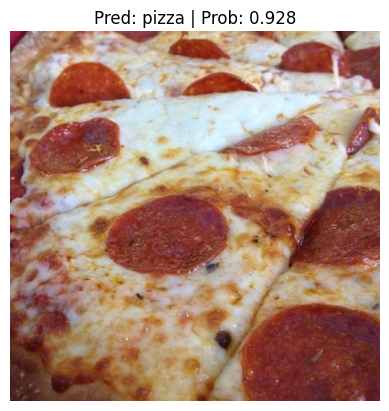

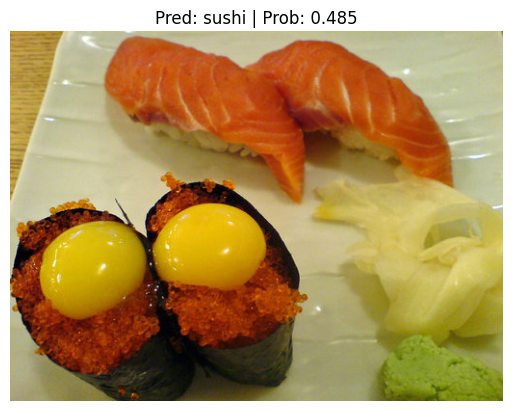

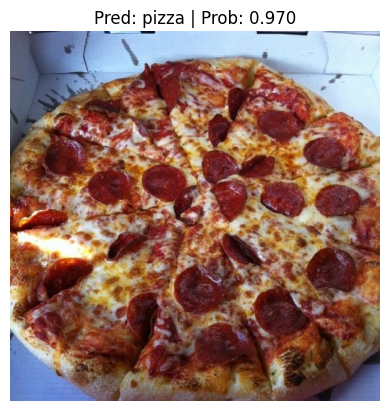

In [ ]:
# Import function to make predictions on images and plot them
# See the function previously created in section: https://www.learnpytorch.io/06_pytorch_transfer_learning/#6-make-predictions-on-images-from-the-test-set
from going_modular.going_modular.predictions import pred_and_plot_image

# Get a random list of 3 images from 20% test set
import random
num_images_to_plot = 3
# get all test image paths from 20% dataset
test_image_path_list = list(
    Path(data_20_percent_path / "test").glob("*/*.jpg"))
test_image_path_sample = random.sample(
    population=test_image_path_list,
    k=num_images_to_plot)  # randomly select k number of images

# Iterate through random test image paths, make predictions on them and plot them
for image_path in test_image_path_sample:
    pred_and_plot_image(
        model=best_model,
        image_path=image_path,
        class_names=class_names,
        image_size=(224, 224))

9.1- Predict on a custom image with the best model


In [ ]:
# Download custom image
import requests

# Setup custom image path
custom_image_path = Path("data/04-pizza-dad.jpeg")

# Download the image if it doesn't already exist
if not custom_image_path.is_file():
    with open(custom_image_path, "wb") as f:
        # When downloading from GitHub, need to use the "raw" file link
        request = requests.get(
            "https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/images/04-pizza-dad.jpeg")
        print(f"Downloading {custom_image_path}...")
        f.write(request.content)
else:
    print(f"{custom_image_path} already exists, skipping download.")

# Predict on custom image
pred_and_plot_image(
    model=model,
    image_path=custom_image_path,
    class_names=class_names)